[comment]: <> (CIMR Level-2 Terrestrial Snow Area)

# CIMR L2 TSA Processing Chain for the Demonstration Reference Scenario (PICASSO)

In [1]:
import os 
import sys
import numpy as np
import xarray as xr
import pyresample as pr
import importlib
from matplotlib import pyplot as plt
from matplotlib import colors

# local imports
if '/tools/' not in sys.path:
    sys.path.insert(0, os.path.abspath('../.../') + 'algorithm/tools/')
import l2_format as l2
import TSA_algorithm as algorithm
import l2_tools as tools

In [2]:
# reload local imports
importlib.reload(l2)
importlib.reload(algorithm)
importlib.reload(tools)

<module 'l2_tools' from 'C:\\Users\\zschende\\OneDrive - Ilmatieteen laitos\\Files\\Projects\\CIMR Devalgo\\ATBD\\TerrestrialSnowArea_ATBD_v2\\algorithm/tools\\l2_tools.py'>

In [3]:
algo = 'Pulliainen2010'
algo_version = '0.9.0'

l1x_scenes = ('devalgo_geometric', 'devalgo_radiometric', 'sceps_polar1')
l2_grids = ('ease2-3.125km-nh','ease2-1.0km-testcard')

In [4]:
# set test_card_name
test_card_name = l1x_scenes[1]      # alternative: test_card_name = l1x_scenes[0]
l2_grid = l2_grids[0]               # nominal L2 product grid

In [5]:
if test_card_name == 'devalgo_geometric':    
    # DEVALGO simulated geometric test card
    l1x_path = os.path.abspath('../../../..../') + 'Data/L1C Files/Geometric/'
    l1x_fn = 'W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
elif test_card_name == 'devalgo_radiometric':
    # DEVALGO simulated radiometric test card
    l1x_path = os.path.abspath('../../../..../') + 'Data/L1C Files/Radiometric/'
    l1x_fn = 'W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'

## Step 1: Dry Snow Detection

In [6]:
# read L1X data
data_fwd,geo_fwd,data_bck,geo_bck = tools.read_l1x(l1x_path + l1x_fn)

In [7]:
# detection forward and backward
TSA_fwd = algorithm.dry_snow_detection(data_fwd,tsa_algorithm=algo)
TSA_bck = algorithm.dry_snow_detection(data_bck,tsa_algorithm=algo)

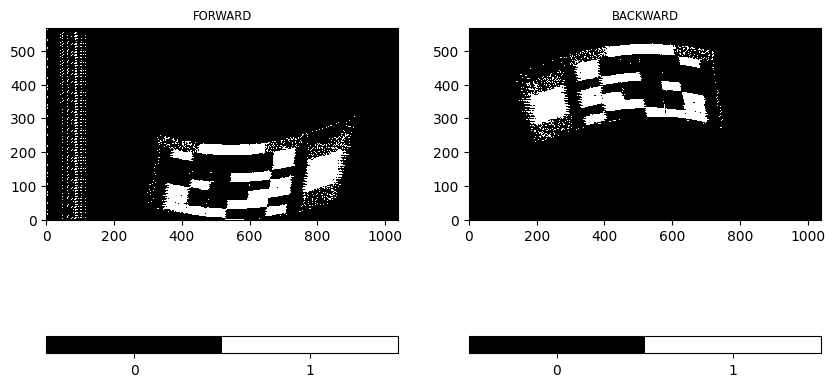

In [8]:
cmap = colors.ListedColormap(['black', 'white'])
vrange=[0,.5,1]
# cmap.set_bad(color='red')

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,10))

img = ax[0].imshow(TSA_fwd, vmin=0, vmax=1, interpolation='none', origin='lower', cmap=cmap)
ax[0].set_title('FORWARD', fontsize='small')
# plt.text(0.01,0.99,'TSA',va='top',color='white')
cbar = plt.colorbar(img, boundaries=vrange, ticks=[0.25, 0.75], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '1'])

img = ax[1].imshow(TSA_bck, vmin=0, vmax=1, interpolation='none', origin='lower', cmap=cmap)
ax[1].set_title('BACKWARD', fontsize='small')
# plt.text(0.01,0.99,'TSA',va='top',color='white')
cbar = plt.colorbar(img, boundaries=vrange, ticks=[0.25, 0.75], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '1'])
    
# fig.savefig('tsa_swath.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

## Step 2: Combined Reprojection

Reprojection for nominal TSA product: EASE2 3.125km

Note that for the Algorithm Performance Assessment, the target grid is the same as the Test Card, namely EASE2 1km.

In [9]:
area_def = pr.load_area('ease2_adef.yaml',l2_grid)

cart_crs = area_def.to_cartopy_crs()
# extent = cart_crs.bounds
# trg_lon, trg_lat = area_def.get_lonlats()

### Step 2.1: Individual Reprojection

In [10]:
TSA_fwd_proj = tools.reproject_to_grid(TSA_fwd,geo_fwd,area_def=area_def)
TSA_bck_proj = tools.reproject_to_grid(TSA_bck,geo_bck,area_def=area_def)

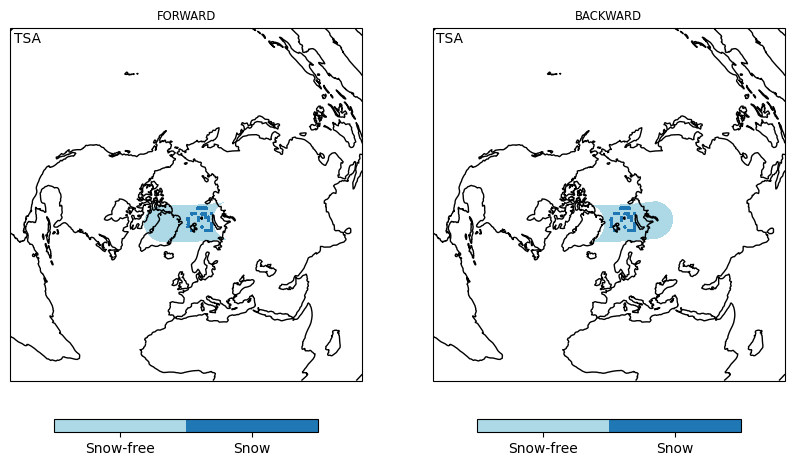

In [11]:
cmap = colors.ListedColormap(['lightblue', 'tab:blue'])
# cmap.set_bad(color='lightgrey')

vrange = [-0.5,0.5,1.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10),
                       subplot_kw=dict(projection=cart_crs))

img = ax[0].imshow(TSA_fwd_proj, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap)
ax[0].coastlines(color='black')
ax[0].set_title('FORWARD', fontsize='small')
ax[0].text(0.01,0.99,'TSA',va='top',transform=ax[0].transAxes)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1], orientation='horizontal', pad=0.05, shrink=0.75)
cbar.ax.set_xticklabels(['Snow-free', 'Snow'])

img = ax[1].imshow(TSA_bck_proj, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap)
ax[1].coastlines(color='black')
ax[1].set_title('BACKWARD', fontsize='small')
ax[1].text(0.01,0.99,'TSA',va='top',transform=ax[1].transAxes)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1], orientation='horizontal', pad=0.05, shrink=0.75)
cbar.ax.set_xticklabels(['Snow-free', 'Snow'])

# plt.savefig('tsa_fwdbck.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

### Step 2.2: Combining Reprojections

In [12]:
# intermediate combined data
TSA_comb, TSA_comb_uncert = tools.combine_proj(TSA_fwd_proj,TSA_bck_proj)

## Step 3: Masking and Flagging

In [13]:
# load surface information
if test_card_name == 'devalgo_geometric':
    dem_ref_scenario = os.path.abspath('../../../..../') + 'Data/Test_scenes_downscaled_projected/test_scene_2_compressed_lowres.nc'
elif test_card_name == 'devalgo_radiometric':
    dem_ref_scenario = os.path.abspath('../../../..../') + 'Data/Test_scenes_downscaled_projected/test_scene_1_compressed_lowres.nc'

data_tc = xr.open_dataset(dem_ref_scenario)
swath_def = pr.geometry.SwathDefinition(lons=data_tc['Longitude'].values, lats=data_tc['Latitude'].values)
land_mask = pr.kd_tree.resample_nearest(swath_def, np.float64(data_tc['landflag'].values), area_def,
                        radius_of_influence=20000/4, fill_value=np.nan)

data_tc.close()

In [14]:
# status_flag
TSA_status_flag = np.zeros(TSA_comb.shape, dtype='i8')

TSA_status_flag[TSA_status_flag == 0] = 8                    # 8: no data, out of grid
TSA_status_flag[land_mask == 0] = 0                          # 0: water
TSA_status_flag[(TSA_comb == 0) & (land_mask == 1)] = 1      # 1: land
TSA_status_flag[(TSA_comb == 1) & (land_mask == 1)] = 2      # 2: valid snow
# TSA_status_flag[] = 3                                      # 3: [placeholder]

status_flag_comment = '0: water; 1: land; 2: snow (valid); 3-7: [placeholders]; 8: no data, out of grid.'

In [15]:
# TSA_uncertainty
TSA_uncertainty = np.zeros(TSA_comb.shape, dtype='i8') 

TSA_uncertainty[TSA_comb_uncert == 0] = 0                    # 0: very likely snow-free
TSA_uncertainty[TSA_comb_uncert == 0.5] = 1                  # 1: likely snow
TSA_uncertainty[TSA_comb_uncert == 1] = 2                    # 2: very likely snow

In [16]:
# TSA
TSA_l2 = TSA_comb
# TSA_l2 = np.zeros(TSA_status_flag.shape)

# TSA_l2[TSA_l2 == 0] = np.nan                                 # nan: no data, out of grid
# TSA_l2[TSA_comb == 0] = 0                                    # 0: snow free
# TSA_l2[TSA_comb == 1] = 1                                    # 1: snow covered (dry)
# TSA_l2[TSA_comb == 2] = 2                                    # 2: snow covered (wet) [placeholder]

## Visualization of Final Level-2 TSA Variables

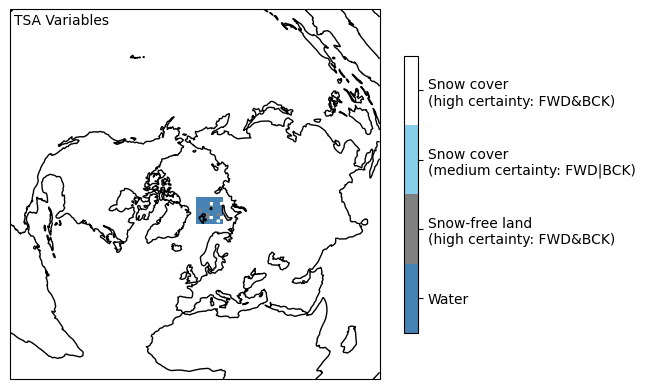

In [17]:
TSA_map = TSA_l2.copy()

if test_card_name == 'devalgo_geometric':
    TSA_map_flag = np.zeros(TSA_l2.shape)
    TSA_map_flag[TSA_status_flag == 8] = np.nan
    # TSA_map_flag[TSA_status_flag == 0] = 0                              # water
    TSA_map_flag[(TSA_status_flag == 0) & (TSA_uncertainty == 0)] = 1   # snow-free (very likely)
    TSA_map_flag[(TSA_status_flag == 0) & (TSA_uncertainty == 1)] = 2   # snow cover (likely)
    TSA_map_flag[(TSA_status_flag == 0) & (TSA_uncertainty == 2)] = 3   # snow cover (very likely)

    ax = plt.axes(projection=cart_crs)
    cmap = colors.ListedColormap(['grey', 'skyblue', 'white'])
    vrange=[0.5,1.5,2.5,3.5]
    norm = colors.BoundaryNorm(vrange, cmap.N)

    img = plt.imshow(TSA_map_flag, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
                cmap=cmap)
    ax.coastlines(color='black')
    plt.text(0.01,0.99,'TSA Variables',va='top',transform=ax.transAxes)
    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[1,2,3], fraction=0.031, pad=0.046)
    cbar.ax.set_yticklabels(['Snow-free\n(high certainty: FWD&BCK)', 'Snow\n(medium certainty: FWD|BCK)', 'Snow\n(high certainty: FWD&BCK)'])

elif test_card_name == 'devalgo_radiometric':
    TSA_map_flag = np.zeros(TSA_l2.shape)
    TSA_map_flag[TSA_status_flag == 8] = np.nan
    TSA_map_flag[TSA_status_flag == 0] = 0                              # water
    TSA_map_flag[(TSA_status_flag == 1) & (TSA_uncertainty == 0)] = 1   # snow-free land (very likely)
    TSA_map_flag[(TSA_status_flag == 2) & (TSA_uncertainty == 1)] = 2   # snow cover (likely)
    TSA_map_flag[(TSA_status_flag == 2) & (TSA_uncertainty == 2)] = 3   # snow cover (very likely)

    ax = plt.axes(projection=cart_crs)
    cmap = colors.ListedColormap(['steelblue', 'grey', 'skyblue', 'white'])
    vrange=[-0.5,0.5,1.5,2.5,3.5]
    norm = colors.BoundaryNorm(vrange, cmap.N)

    img = plt.imshow(TSA_map_flag, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
                cmap=cmap)
    ax.coastlines(color='black')
    plt.text(0.01,0.99,'TSA Variables',va='top',transform=ax.transAxes)
    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1,2,3], orientation='vertical', pad=0.05, shrink=0.75)
    cbar.ax.set_yticklabels(['Water', 'Snow-free land\n(high certainty: FWD&BCK)', 'Snow cover\n(medium certainty: FWD|BCK)', 'Snow cover\n(high certainty: FWD&BCK)'])

# fig.savefig('tsa_l2product.png', format='png', dpi=2400, bbox_inches='tight')

plt.show()